<a href="https://colab.research.google.com/github/KavinduJ2001/PR_A03/blob/main/PRA03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = image_segmentation.data.features
y = image_segmentation.data.targets

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)


{'uci_id': 50, 'name': 'Image Segmentation', 'repository_url': 'https://archive.ics.uci.edu/dataset/50/image+segmentation', 'data_url': 'https://archive.ics.uci.edu/static/public/50/data.csv', 'abstract': 'Image data described by high-level numeric-valued attributes, 7 classes', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2310, 'num_features': 19, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C5GP4N', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'The instances were drawn randomly from a database of 7 outdoor images.  The images were handsegmented to create a classification for every pixel.  \r\n\r\n   Each instance is a 3x3 region.', 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_dat

In [4]:
# Display the first few rows of the features and targets
print("\nFirst few rows of features:")
print(X.head())

print("\nFirst few rows of targets:")
print(y.head())



First few rows of features:
   region-centroid-col  region-centroid-row  region-pixel-count  \
0                140.0                125.0                   9   
1                188.0                133.0                   9   
2                105.0                139.0                   9   
3                 34.0                137.0                   9   
4                 39.0                111.0                   9   

   short-line-density-5  short-line-density-2  vedge-mean  vedge-sd  \
0                   0.0                   0.0    0.277778  0.062963   
1                   0.0                   0.0    0.333333  0.266667   
2                   0.0                   0.0    0.277778  0.107407   
3                   0.0                   0.0    0.500000  0.166667   
4                   0.0                   0.0    0.722222  0.374074   

   hedge-mean  hedge-sd  intensity-mean  rawred-mean  rawblue-mean  \
0    0.666667  0.311111        6.185185     7.333334      7.666666   
1

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 126
Validation set size: 42
Testing set size: 42


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.1249 - loss: 2.3443 - val_accuracy: 0.1000 - val_loss: 2.3123
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.1038 - loss: 2.3152 - val_accuracy: 0.1000 - val_loss: 2.3148
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.0923 - loss: 2.3254 - val_accuracy: 0.1100 - val_loss: 2.3098
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.1149 - loss: 2.3074 - val_accuracy: 0.0750 - val_loss: 2.3090
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.1214 - loss: 2.3015 - val_accuracy: 0.1100 - val_loss: 2.3079
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.1297 - loss: 2.3003 - val_accuracy: 0.1050 - val_loss: 2.3128
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.1052 - loss: 2.3035 - val_accuracy: 0.1100 - val_loss: 2.3061
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.1078 - loss: 2.2968 - val_accuracy:

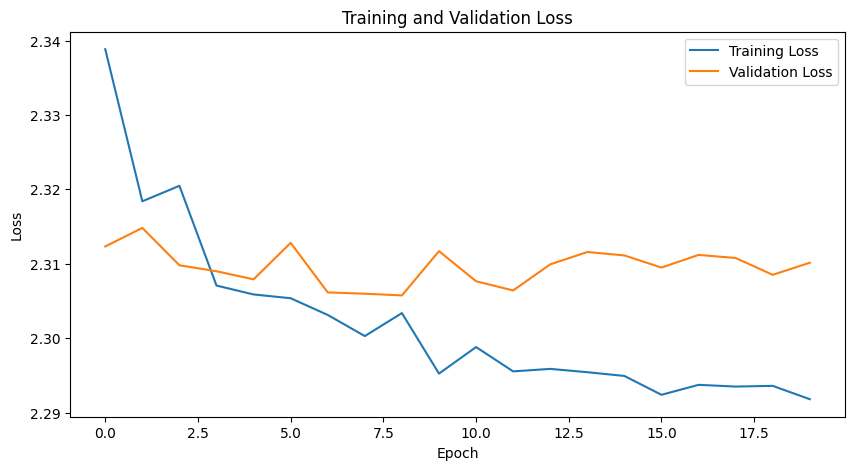

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define parameters
x1, m1 = 32, 3  # Filters and kernel size for the first convolutional layer
x2, m2 = 64, 3  # Filters and kernel size for the second convolutional layer
x3 = 128        # Units in the fully connected layer
d = 0.5         # Dropout rate
K = 10          # Number of output classes
learning_rate = 0.00001

# Build the CNN model
model = Sequential([
    Conv2D(filters=x1, kernel_size=(m1, m1), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=x2, kernel_size=(m2, m2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=x3, activation='relu'),
    Dropout(rate=d),
    Dense(units=K, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Generate dummy training and validation data
# Replace this with your actual dataset
import numpy as np
X_train = np.random.rand(1000, 64, 64, 3)
y_train = np.random.randint(0, K, 1000)
X_val = np.random.rand(200, 64, 64, 3)
y_val = np.random.randint(0, K, 200)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
